## import libararies



In [1]:
import openeo
import config as config
print(config.SPATIAL_EXTENT)
print(config.MAX_CLOUD_COVER)


{'west': 677736, 'south': 624010, 'east': 694576, 'north': 638629, 'crs': 'EPSG:32629'}
75


## Create a process graph

In [2]:
from geospatial_pipeline.input_cube_loader import load_input_cube
from geospatial_pipeline.band_normalization import normalize_cube
from geospatial_pipeline.onnx_inference import run_inference


connection = openeo.connect("https://openeo.dataspace.copernicus.eu/")
connection.authenticate_oidc()


input_cube = load_input_cube(
        connection,
        spatial_extent=config.SPATIAL_EXTENT,
        temporal_extent=config.TEMPORAL_EXTENT,
        max_cloud_cover=config.MAX_CLOUD_COVER,
        resolution=config.RESOLUTION,
        crs=config.CRS
    )

cube_normalised = normalize_cube(input_cube)

cube_normalised


Authenticated using refresh token.


# Let's get the input data

In [3]:
input_save_cube = cube_normalised.save_result(format = "netCDF")
job = connection.create_job(input_save_cube,
    additional=config.JOB_OPTIONS
)
job.start_and_wait()


0:00:00 Job 'j-250923050957487b937d0b5c9b4128e8': send 'start'
0:00:13 Job 'j-250923050957487b937d0b5c9b4128e8': queued (progress 0%)
0:00:18 Job 'j-250923050957487b937d0b5c9b4128e8': queued (progress 0%)
0:00:25 Job 'j-250923050957487b937d0b5c9b4128e8': queued (progress 0%)
0:00:33 Job 'j-250923050957487b937d0b5c9b4128e8': queued (progress 0%)
0:00:43 Job 'j-250923050957487b937d0b5c9b4128e8': queued (progress 0%)
0:00:55 Job 'j-250923050957487b937d0b5c9b4128e8': queued (progress 0%)
0:01:11 Job 'j-250923050957487b937d0b5c9b4128e8': running (progress N/A)
0:01:30 Job 'j-250923050957487b937d0b5c9b4128e8': running (progress N/A)
0:01:54 Job 'j-250923050957487b937d0b5c9b4128e8': running (progress N/A)
0:02:24 Job 'j-250923050957487b937d0b5c9b4128e8': running (progress N/A)
0:03:01 Job 'j-250923050957487b937d0b5c9b4128e8': running (progress N/A)
0:03:48 Job 'j-250923050957487b937d0b5c9b4128e8': running (progress N/A)
1:13:40 Job 'j-250923050957487b937d0b5c9b4128e8': finished (progress 100%

<BatchJob job_id='j-250923050957487b937d0b5c9b4128e8'>

# Visualise the input

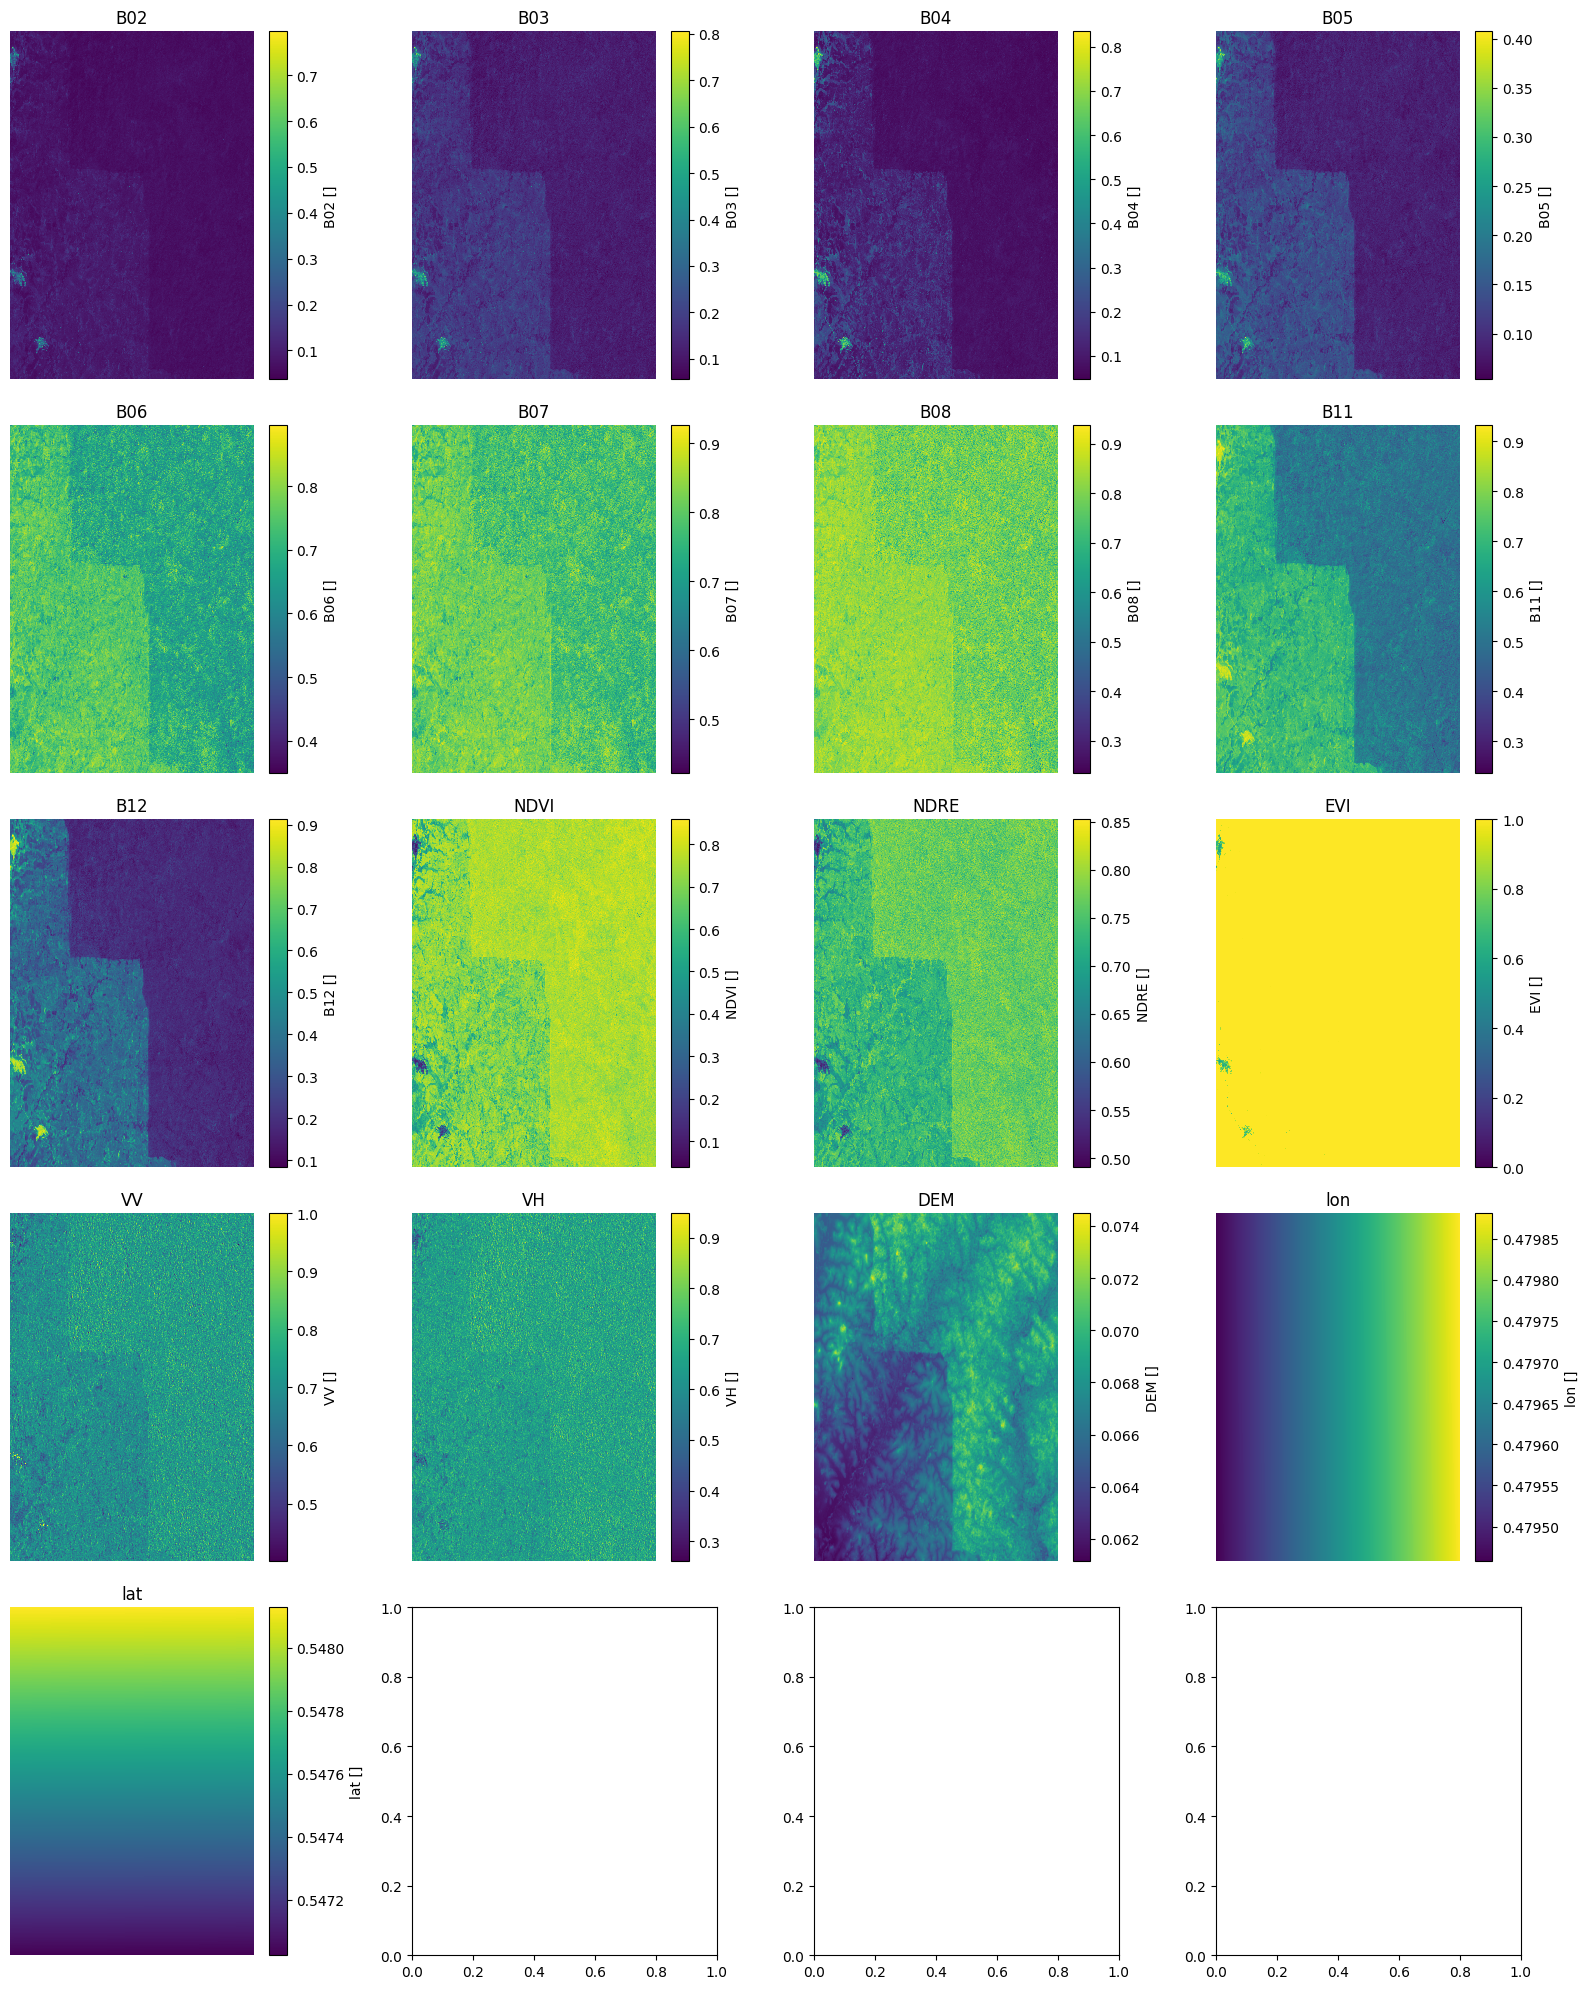

In [4]:
import xarray as xr
import matplotlib.pyplot as plt

output_dir = "C:\\Git_projects\\WAC\\classification\\test_input_norm\\" + job.job_id
path = job.get_results().download_files(f"{output_dir}")
ds = xr.open_dataset(path[0])
time_step = 0

# Filter only variables with dimensions (t, y, x)
variables_to_plot = [var for var in ds.data_vars if {'t', 'y', 'x'}.issubset(ds[var].dims)]

n = len(variables_to_plot)
ncols = 4  # adjust based on how wide you want the figure
nrows = -(-n // ncols)  # ceiling division

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))

# Loop through variables and plot with fixed color scale
for i, var in enumerate(variables_to_plot):
    data = ds[var].isel(t=time_step)

    ax = axes.flat[i]
    im = data.plot(ax=ax, add_colorbar=True)  # no individual colorbar
    ax.set_title(var)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Extend the process graph to include the ML inference

In [ ]:

# Run inference
inference_cube = run_inference(
    cube_normalised,
    model_name=config.MODEL_NAME,
    patch_size=config.PATCH_SIZE,
    overlap=config.OVERLAP_SIZE
)

class_labels = [config.CLASS_MAPPING[i] for i in sorted(config.CLASS_MAPPING)] + ["ARGMAX"]
inference_cube = inference_cube.rename_labels(dimension='bands', target=class_labels)

save_inference_cube = inference_cube.save_result(format = "netCDF")
save_inference_cube




## Execute the ML inference

In [4]:

job = connection.create_job(save_inference_cube,
    additional=config.JOB_OPTIONS
)
job.start_and_wait()

0:00:00 Job 'j-25092214244648fd9123e03a6c831fd1': send 'start'
0:00:13 Job 'j-25092214244648fd9123e03a6c831fd1': created (progress 0%)
0:00:18 Job 'j-25092214244648fd9123e03a6c831fd1': created (progress 0%)
0:00:24 Job 'j-25092214244648fd9123e03a6c831fd1': queued (progress 0%)
0:00:32 Job 'j-25092214244648fd9123e03a6c831fd1': queued (progress 0%)
0:00:42 Job 'j-25092214244648fd9123e03a6c831fd1': queued (progress 0%)
0:00:55 Job 'j-25092214244648fd9123e03a6c831fd1': queued (progress 0%)
0:01:10 Job 'j-25092214244648fd9123e03a6c831fd1': queued (progress 0%)
0:01:29 Job 'j-25092214244648fd9123e03a6c831fd1': queued (progress 0%)
0:01:54 Job 'j-25092214244648fd9123e03a6c831fd1': queued (progress 0%)
0:02:24 Job 'j-25092214244648fd9123e03a6c831fd1': running (progress N/A)
0:03:01 Job 'j-25092214244648fd9123e03a6c831fd1': running (progress N/A)
0:03:48 Job 'j-25092214244648fd9123e03a6c831fd1': running (progress N/A)
0:04:46 Job 'j-25092214244648fd9123e03a6c831fd1': running (progress N/A)
0:50

<BatchJob job_id='j-25092214244648fd9123e03a6c831fd1'>

# Visualise the output of the classification

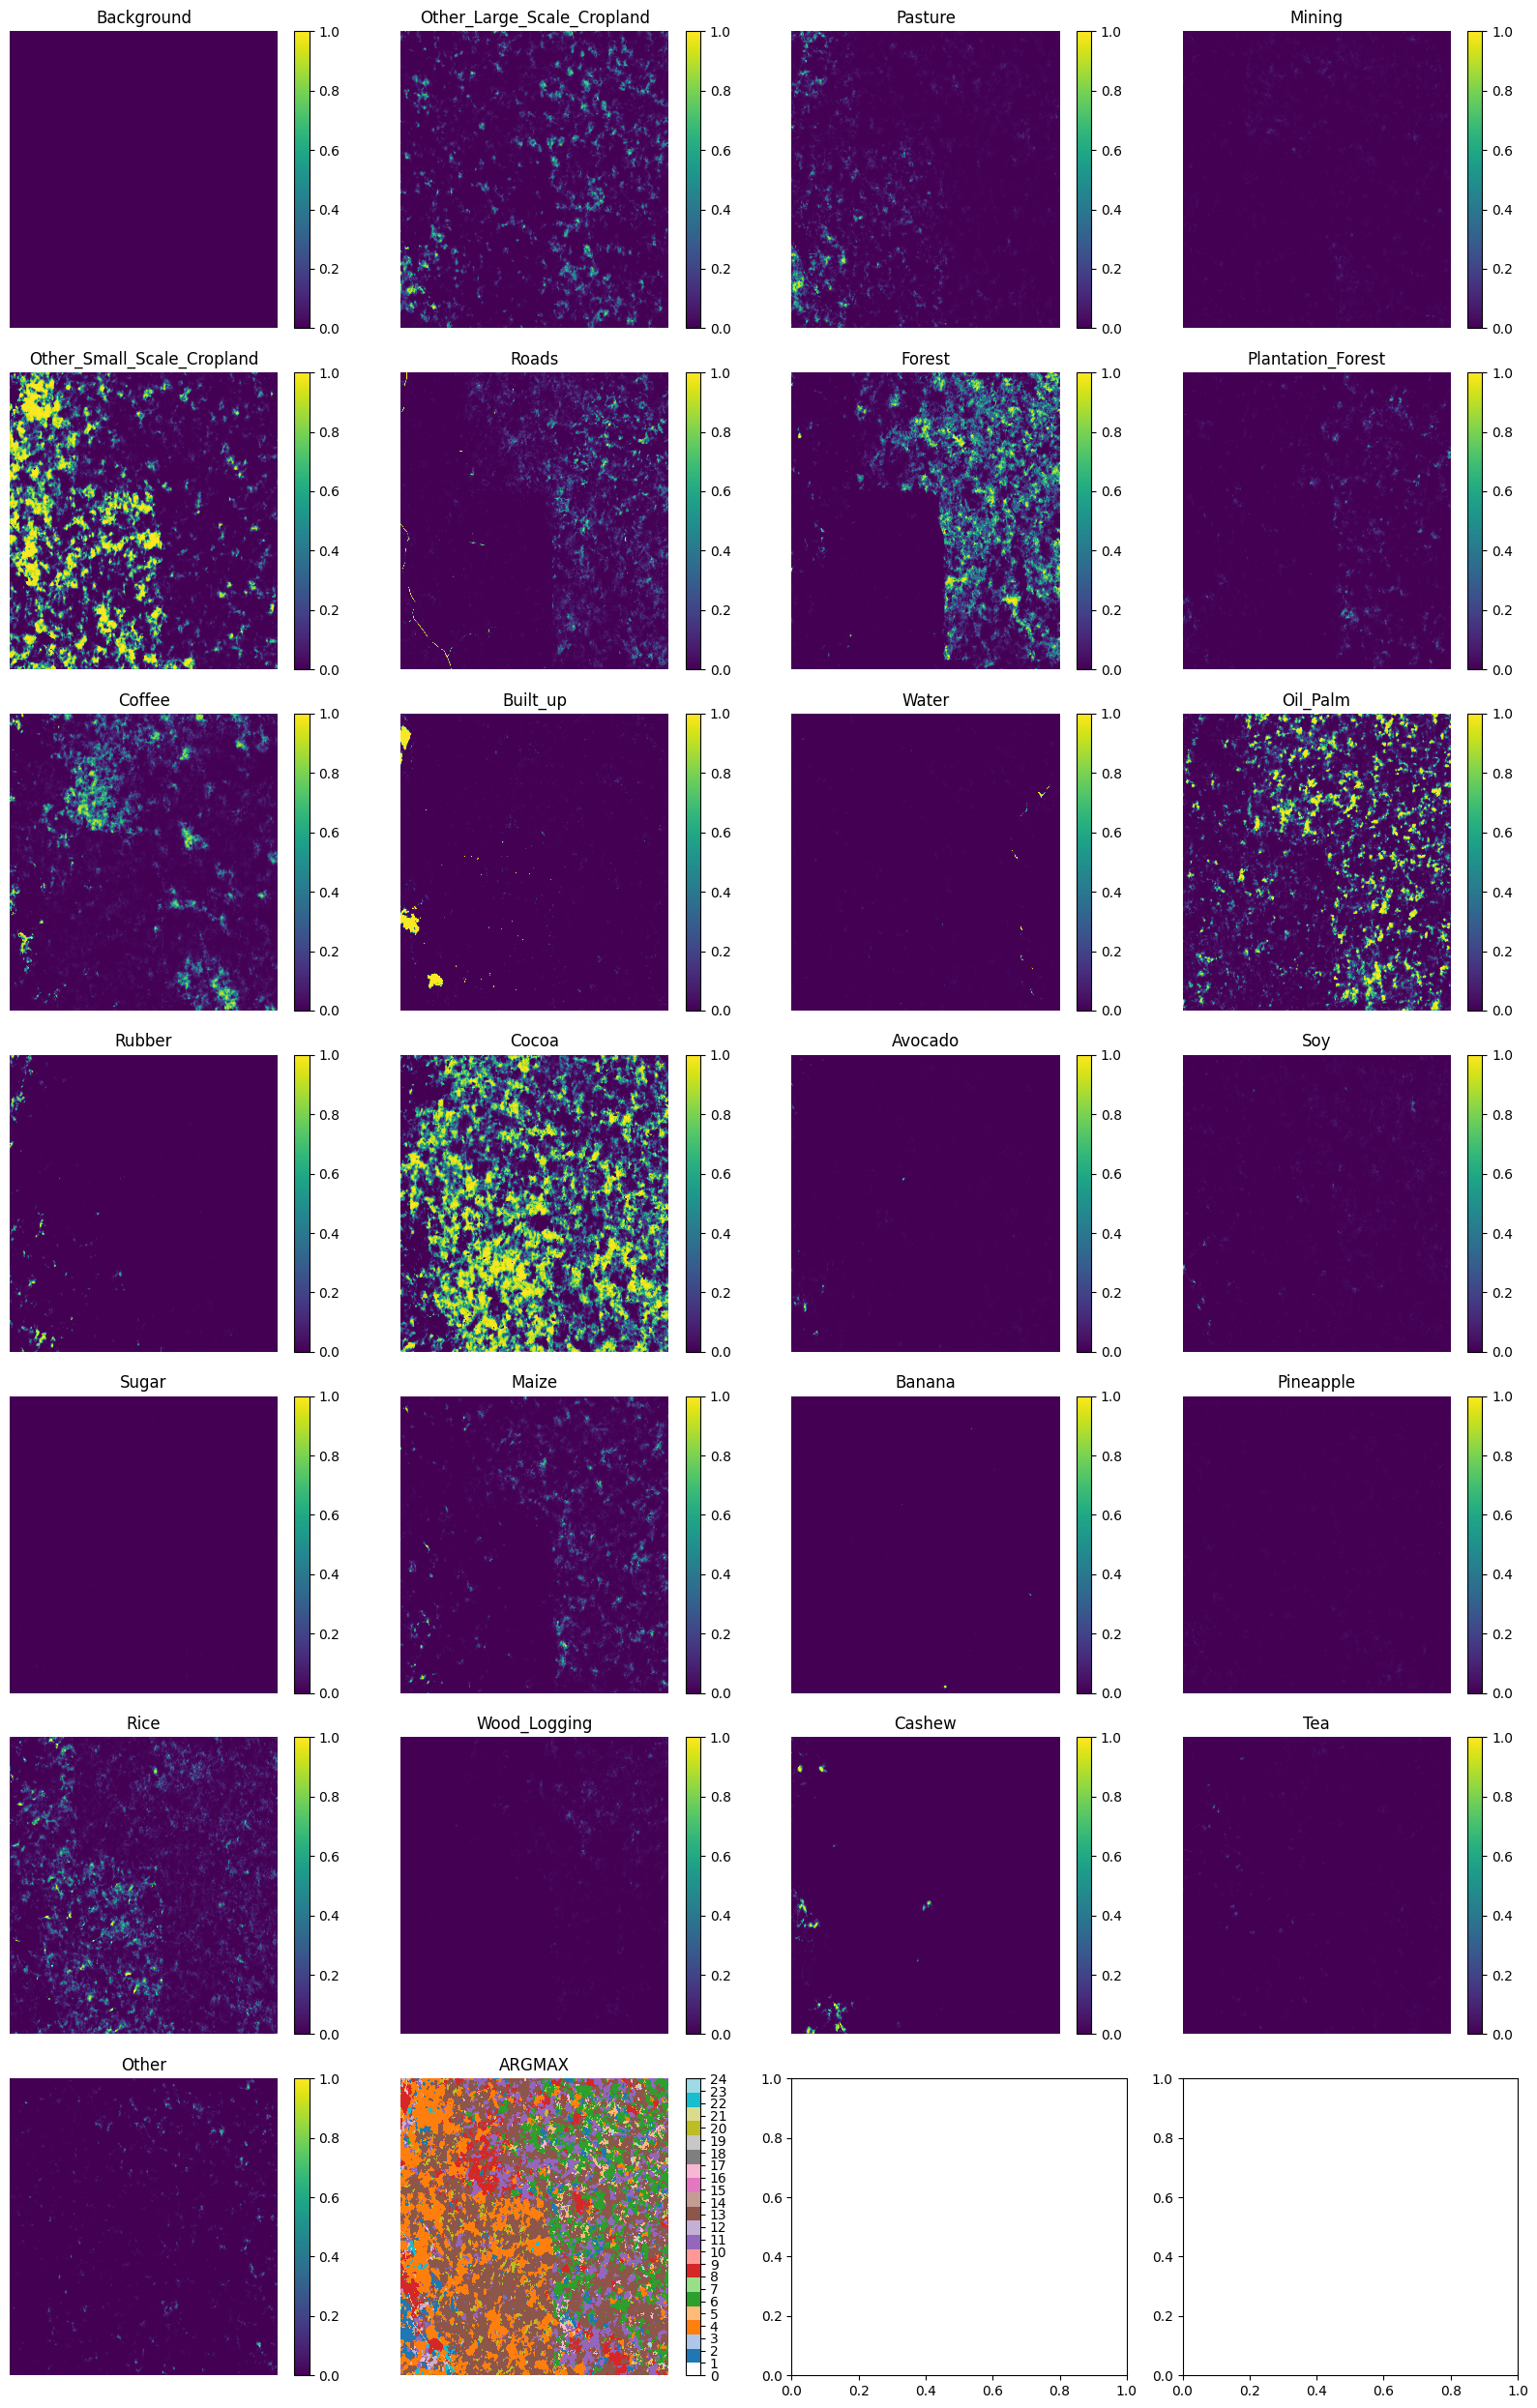

In [11]:
import xarray as xr
import matplotlib.pyplot as plt

ds = xr.open_dataset("C:\\Git_projects\\WAC\\classification\\norm_udf_output\\j-2509240849394ef098f06a1f3507381d\\openEO.nc")

time_step = 0

# --- Select variables with dims (t, y, x) ---
variables_to_plot = [var for var in ds.data_vars if {'t', 'y', 'x'}.issubset(ds[var].dims)]

n = len(variables_to_plot)
ncols = 4
nrows = -(-n // ncols)  # ceiling division

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 25))

# --- Classification variable = last one ---
classification_var = variables_to_plot[-1]

# Classes correspond to the *indices* of the other variable names
class_ids = list(range(len(variables_to_plot) - 1))
class_labels = variables_to_plot[:-1]   # use band names as labels

# --- Loop through variables ---
for i, var in enumerate(variables_to_plot):
    data = ds[var].isel(t=time_step)
    ax = axes.flat[i]

    if var == classification_var:
        # Classification plot with discrete colormap
        im = data.plot(
            ax=ax,
            cmap="tab20",   # discrete
            add_colorbar=True,
            add_labels=False
        )

        # Adjust colorbar ticks + labels
        cbar = im.colorbar
        cbar.set_ticks(class_ids)
        cbar.set_ticklabels(class_ids)

    else:
        # Continuous variables: fixed 0–1 scale
        im = data.plot(
            ax=ax,
            cmap="viridis",
            vmin=0,
            vmax=1,
            add_colorbar=True,
            add_labels=False
        )

    ax.set_title(var)
    ax.axis("off")

plt.tight_layout()
plt.show()
